In [1]:
# imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import seaborn as sns
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

import time
from alpha import Alpha

In [2]:
plt.style.use('seaborn-v0_8')
colourmap = pl.cm.cool(np.linspace(0, 1, 4))

In [3]:
start = time.time()

In [4]:
# dataloader arguments
batch_size = 200
data_path = '/tmp/data/fmnist'

dtype = torch.float
device = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [5]:
# Define a transform
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))])

fmnist_train = datasets.FashionMNIST(
    data_path, train=True, download=True, transform=transform)
fmnist_test = datasets.FashionMNIST(data_path, train=False,
                            download=True, transform=transform)

In [6]:
# Create DataLoaders
train_loader = DataLoader(
    fmnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(
    fmnist_test, batch_size=batch_size, shuffle=True, drop_last=True)

In [7]:
# Define Network parameters
num_steps = 50

In [8]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Initialize layers
        self.convq1 = nn.Conv2d(1, 12, 5)
        self.convt1 = nn.Conv2d(1, 12, 5)
        # 12 filters, 24x24 each after conv1
        self.lif1 = Alpha(N=12 * 24 * 24, device=device)

        self.convq2 = nn.Conv2d(12, 64, 5)
        self.convt2 = nn.Conv2d(12, 64, 5)
        # 64 filters, 8x8 each after conv2
        self.lif2 = Alpha(N=64 * 8 * 8, device=device)

        self.fcq1 = nn.Linear(64 * 4 * 4, 10)
        self.fct1 = nn.Linear(64 * 4 * 4, 10)
        self.lif3 = Alpha(N=10, device=device)

    def forward(self, x):
        # Initialize hidden states at t=0
        mem1 = self.lif1.reset_mem()
        mem2 = self.lif2.reset_mem()
        mem3 = self.lif3.reset_mem()

        # Record the final layer
        spk3_rec = []
        mem3_rec = []

        for step in range(num_steps):
            # First convolutional layer
            theta1 = torch.abs(self.convq1(x)) * torch.pi
            tau1 = torch.abs(self.convt1(x)) * 200
            spk_in1 = torch.where(self.convq1(
                x) > 0, torch.tensor(1), torch.tensor(0))

            # Flattening the output before passing to Alpha neuron
            spk_in1 = spk_in1.view(spk_in1.size(0), -1)
            theta1 = theta1.view(theta1.size(0), -1)
            tau1 = tau1.view(tau1.size(0), -1)

            spk1, mem1 = self.lif1(theta1, tau1, spk_in1)
            spk1 = spk1.view(-1, 12, 24, 24)
            spk1 = F.max_pool2d(spk1, 2)

            # Second convolutional layer
            theta2 = torch.abs(self.convq2(spk1)) * torch.pi
            tau2 = torch.abs(self.convt2(spk1)) * 200
            spk_in2 = torch.where(self.convq2(spk1) > 0,
                                  torch.tensor(1), torch.tensor(0))

            # Flattening the output before passing to Alpha neuron
            spk_in2 = spk_in2.view(spk_in2.size(0), -1)
            theta2 = theta2.view(theta2.size(0), -1)
            tau2 = tau2.view(tau2.size(0), -1)

            spk2, mem2 = self.lif2(theta2, tau2, spk_in2)
            spk2 = spk2.view(-1, 64, 8, 8)
            spk2 = F.max_pool2d(spk2, 2)

            # Fully connected layer
            theta3 = torch.abs(
                self.fcq1(spk2.view(spk2.size(0), -1))) * torch.pi
            tau3 = torch.abs(self.fct1(spk2.view(spk2.size(0), -1))) * 200
            spk_in3 = torch.where(
                self.fcq1(spk2.view(spk2.size(0), -1)) > 0, torch.tensor(1), torch.tensor(0))

            spk3, mem3 = self.lif3(theta3, tau3, spk_in3)

            spk3_rec.append(spk3)
            mem3_rec.append(mem3)

        return torch.stack(spk3_rec, dim=0), torch.stack(mem3_rec, dim=0)

In [9]:
# Load the network onto CUDA if available
net = Net().to(device)

In [10]:
# Function to print batch accuracy
def print_batch_accuracy(data, targets, train=False):
    output, _ = net(data)
    _, idx = output.sum(dim=0).max(1)
    acc = np.mean((targets == idx).detach().cpu().numpy())

    if train:
        print(f"Train set accuracy for a single minibatch: {acc*100:.2f}%")
    else:
        print(f"Test set accuracy for a single minibatch: {acc*100:.2f}%")

In [11]:
# Function to print training progress
def train_printer(data, targets, epoch, counter, iter_counter, loss_hist, test_loss_hist, test_data, test_targets):
    print(f"Epoch {epoch}, Iteration {iter_counter}")
    print(f"Train Set Loss: {loss_hist[counter]:.2f}")
    print(f"Test Set Loss: {test_loss_hist[counter]:.2f}")
    print_batch_accuracy(data, targets, train=True)
    print_batch_accuracy(test_data, test_targets, train=False)
    print("\n")

In [12]:
# Define loss and optimizer
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=5e-4, betas=(0.9, 0.999))
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

In [13]:
num_epochs = 2
loss_hist = []
test_loss_hist = []
counter = 0

In [ ]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(train_loader)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # Initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(mem_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        with torch.no_grad():
            net.eval()
            test_data, test_targets = next(iter(test_loader))
            test_data = test_data.to(device)
            test_targets = test_targets.to(device)

            # Test set forward pass
            test_spk, test_mem = net(test_data)

            # Test set loss
            test_loss = torch.zeros((1), dtype=dtype, device=device)
            for step in range(num_steps):
                test_loss += loss(test_mem[step], test_targets)
            test_loss_hist.append(test_loss.item())

            # Print train/test loss/accuracy
            if counter % 50 == 0:
                train_printer(data, targets, epoch, counter, iter_counter,
                              loss_hist, test_loss_hist, test_data, test_targets)
            counter += 1
            iter_counter += 1

total = 0
correct = 0

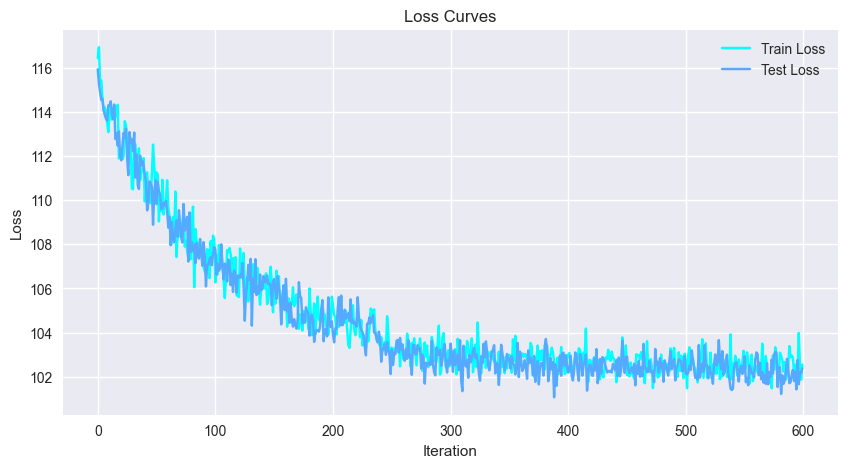

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(10, 5))
plt.plot(loss_hist, color=colourmap[0])
plt.plot(test_loss_hist, color=colourmap[1])
plt.title("Loss Curves")
plt.legend(["Train Loss", "Test Loss"])
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
# Drop_last switched to False to keep all samples
test_loader = DataLoader(
    fmnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
  net.eval()
  for data, targets in test_loader:
    data = data.to(device)
    targets = targets.to(device)

    # Forward pass
    test_spk, _ = net(data)

    # Calculate total accuracy
    _, predicted = test_spk.sum(dim=0).max(1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

In [ ]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")

Total correctly classified test set images: 8184/10000
Test Set Accuracy: 81.84%


In [ ]:
end = time.time()

In [ ]:
print("Time taken: ", time.strftime("%H:%M:%S", time.gmtime(end-start)))

Time taken:  00:05:41


In [ ]:
end-start

341.6598610877991

## Metrics

In [ ]:
total = 0
correct = 0

# Collect all predictions and true labels
all_preds = []
all_targets = []

# drop_last switched to False to keep all samples
test_loader = DataLoader(
    fmnist_test, batch_size=batch_size, shuffle=True, drop_last=False)

with torch.no_grad():
    net.eval()
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        if data.view(data.size(0), -1).shape[0] != batch_size:
            continue

        # forward pass
        test_spk, _ = net(data)

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

        # Collect predictions and true labels
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

In [ ]:
# Convert lists to numpy arrays for metric calculations
all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, average='weighted')
recall = recall_score(all_targets, all_preds, average='weighted')
f1 = f1_score(all_targets, all_preds, average='weighted')

In [ ]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Total correctly classified test set images: 8184/10000
Test Set Accuracy: 81.84%
Precision: 0.7421
Recall: 0.8184
F1-Score: 0.7773


## Detailed Metrics

In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 966    2    1    0    0    5    5    1    0    0]
 [   0 1119    3    5    0    2    6    0    0    0]
 [  13    6  938   12   19    1   18   24    0    1]
 [   8    9   31  910    2   23    1   18    0    8]
 [   1    7    4    0  842    0   26    2    0  100]
 [  20   11    4   74    7  761    6    2    0    7]
 [  21   12    2    0    5   23  895    0    0    0]
 [   5   24   42    0   10    3    0  890    0   54]
 [  59  138   92  174   22  275   46   40    0  128]
 [  21   12   11   13   65    4    1   19    0  863]]


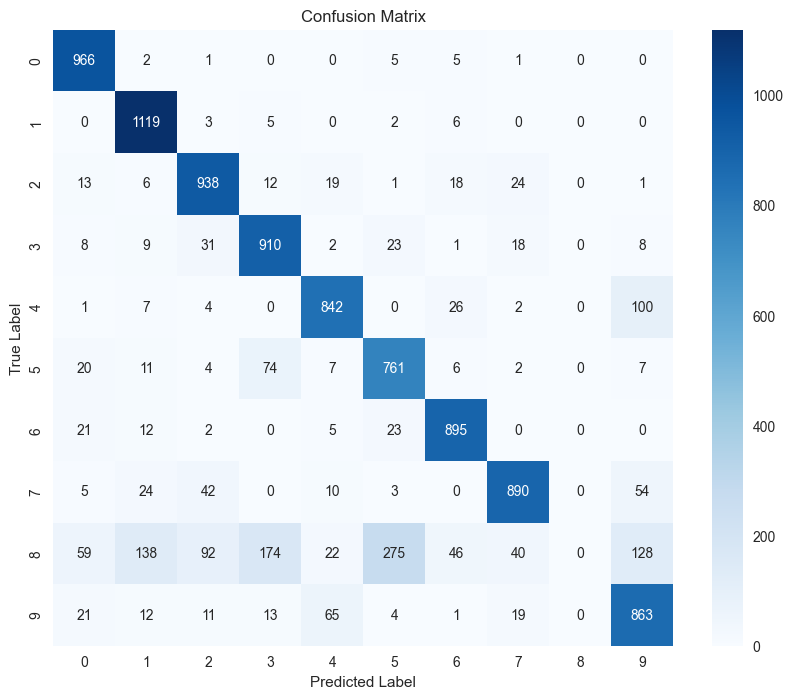

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Class-wise Performance
class_precision = precision_score(all_targets, all_preds, average=None)
class_recall = recall_score(all_targets, all_preds, average=None)
class_f1 = f1_score(all_targets, all_preds, average=None)

for i in range(len(class_precision)):
    print(f"Class {i}: Precision = {class_precision[i]:.4f}, Recall = {class_recall[i]:.4f}, F1-Score = {class_f1[i]:.4f}")

Class 0: Precision = 0.8671, Recall = 0.9857, F1-Score = 0.9226
Class 1: Precision = 0.8351, Recall = 0.9859, F1-Score = 0.9042
Class 2: Precision = 0.8316, Recall = 0.9089, F1-Score = 0.8685
Class 3: Precision = 0.7660, Recall = 0.9010, F1-Score = 0.8280
Class 4: Precision = 0.8663, Recall = 0.8574, F1-Score = 0.8618
Class 5: Precision = 0.6937, Recall = 0.8531, F1-Score = 0.7652
Class 6: Precision = 0.8914, Recall = 0.9342, F1-Score = 0.9123
Class 7: Precision = 0.8936, Recall = 0.8658, F1-Score = 0.8794
Class 8: Precision = 0.0000, Recall = 0.0000, F1-Score = 0.0000
Class 9: Precision = 0.7433, Recall = 0.8553, F1-Score = 0.7954


c:\Users\6mbra\Programming\QNC\qlif\QSNN\qsnn_env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# ROC Curve and AUC
n_classes = 10
fpr = dict()
tpr = dict()
roc_auc = dict()

# One-hot encode the true labels and predictions for ROC curve calculation
all_targets_one_hot = np.eye(n_classes)[all_targets]
all_preds_one_hot = np.eye(n_classes)[all_preds]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(
        all_targets_one_hot[:, i], all_preds_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

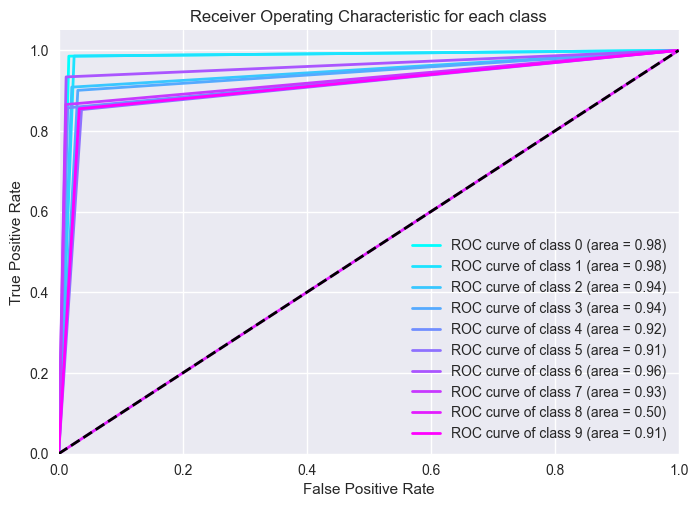

In [ ]:
# Plot ROC curve
colors = pl.cm.cool(np.linspace(0, 1, n_classes))
plt.figure()
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
                   ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
mean_roc_auc = np.mean(list(roc_auc.values()))
mean_roc_auc

0.8972813488435193

In [ ]:
print(f"Total correctly classified test set images: {correct}/{total}")
print(f"Test Set Accuracy: {100 * correct / total:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Total correctly classified test set images: 8184/10000
Test Set Accuracy: 81.84%
Precision: 0.7421
Recall: 0.8184
F1-Score: 0.7773
